In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/COMP90086_2024_Project_train.zip /content/train.zip
!cp /content/drive/My\ Drive/COMP90086_2024_Project_test.zip /content/test.zip

In [ ]:
!unzip /content/train.zip -d /content/
!unzip /content/test.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/COMP90086_2024_Project_train/train/649018.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/649301.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/649460.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/649643.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/649756.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/649948.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/64996.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/650541.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/650557.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/650678.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/6507.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/650779.jpg  
  inflating: /content/COMP90086_2024_Project_train/train/651444.jpg  
  inflating: /content/COMP90086_2024_Proje

In [ ]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate, LayerNormalization, Layer)
from tensorflow.keras.applications import ResNet50, InceptionResNetV2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2 # type: ignore
import skimage.io
import skimage.io
from skimage import color, morphology, measure
import skimage.filters
import skimage.util
from skimage import measure, morphology

In [ ]:
def fix_color(image):
    # Convert the input image from BGR to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply Bilateral Filter to reduce noise while preserving edges
    bilateral_filtered = cv2.bilateralFilter(hsv, d=9, sigmaColor=75, sigmaSpace=75)

    # Split the HSV image into its three channels: H, S, and V
    h, s, v = cv2.split(bilateral_filtered)

    # Apply Contrast Limited Adaptive Histogram Equalization to enhance the V channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)

    # Merge the processed V channel back with the original H and S channels
    hsv_clahe = cv2.merge((h, s, v_clahe))

    # Convert the processed HSV image back to BGR color space
    processed_image = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2BGR)

    # Perform morphological closing to fill small holes and solidify regions
    kernel = np.ones((5, 5), np.uint8)
    morph_closed_image = cv2.morphologyEx(processed_image, cv2.MORPH_CLOSE, kernel)

    return morph_closed_image


def preprocess_image(images):
    # Initialize an array to hold processed images with the same shape as the input
    processed_images = np.zeros_like(images)

    # Iterate over each image in the input array
    for idx, img in enumerate(images):
        # Convert the image to HSV color space
        image_hsv = color.rgb2hsv(img)

        # Define the HSV range for object color detection
        lower_bound = np.array([0.0, 0.2, 0.2])
        upper_bound = np.array([1.0, 1.0, 1.0])

        # Create a binary mask for the object based on the defined HSV color range
        mask = (image_hsv[:, :, 0] >= lower_bound[0]) & (image_hsv[:, :, 0] <= upper_bound[0]) & \
               (image_hsv[:, :, 1] >= lower_bound[1]) & (image_hsv[:, :, 1] <= upper_bound[1]) & \
               (image_hsv[:, :, 2] >= lower_bound[2]) & (image_hsv[:, :, 2] <= upper_bound[2])

        # Clean up the mask by removing small objects and holes
        mask = morphology.remove_small_objects(mask, min_size=500)
        mask = morphology.remove_small_holes(mask, area_threshold=500)

        # Label the connected regions in the mask and extract their properties
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        output = np.zeros_like(img)  # Initialize an output image

        # Loop through each labeled region to extract the largest one
        for region in regions:
            min_row, min_col, max_row, max_col = region.bbox
            output[min_row:max_row, min_col:max_col] = img[min_row:max_row, min_col:max_col]

        # Convert the extracted output to grayscale and apply Gaussian smoothing
        blurred_image = cv2.GaussianBlur((output * 255).astype(np.uint8), (5, 5), 0)

        # Apply Canny edge detection to the blurred image
        edges = cv2.Canny(blurred_image, 100, 200)

        # Dilate the edges to enhance the contours
        kernel = np.ones((5, 5), np.uint8)
        dilated_edges = cv2.dilate(edges, kernel, iterations=1)

        # Find contours in the dilated edges image
        contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_largest_contour = np.zeros_like(img[:, :, 0], dtype=np.uint8)  # Initialize a mask for the largest contour

        # Identify the largest contour if exist
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)

        # Mask the original image to isolate the largest object
        masked_image_largest = cv2.bitwise_and(img, img, mask=mask_largest_contour)

        # Inverse mask to replace the background with white
        mask_inverse = cv2.bitwise_not(mask_largest_contour)
        result = masked_image_largest.copy()
        result[mask_inverse == 255] = [255, 255, 255]  # Set background to white

        # fix_color function to enhance the final color adjustments
        result = fix_color(result)

        # Store the processed image in the output array
        processed_images[idx] = result

    return processed_images


In [ ]:
# Load and preprocess the data from a specified folder and metadata file
def load_data(image_folder, metadata_path, num_samples=None):
    # Load metadata from a CSV file into a DataFrame
    metadata = pd.read_csv(metadata_path)

    # If a specific number of samples is requested, limit the DataFrame to that number of rows
    if num_samples:
        metadata = metadata.head(num_samples)

    return metadata

# Load and preprocess an individual image from a given file path
def load_and_preprocess_image(filepath):
    # Use Keras's load_img function to load an image from the specified filepath
    image = load_img(filepath)
    return image

# Apply image augmentation transformations to a list of images
def img_augmentation(images, transform):
    # Iterate over each image in the list
    for img in images:
        # Apply the specified transformation to the image
        augmented = transform(image=img)
        img = augmented['image']  # Update the image with the augmented version

    return images  # Return the list of augmented images

In [ ]:
# Load the data
image_folder = '/content/COMP90086_2024_Project_train/train'
metadata_path = '/content/COMP90086_2024_Project_train/train.csv'
metadata = load_data(image_folder, metadata_path)

metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7680 entries, 0 to 7679
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                7680 non-null   int64
 1   shapeset          7680 non-null   int64
 2   type              7680 non-null   int64
 3   total_height      7680 non-null   int64
 4   instability_type  7680 non-null   int64
 5   cam_angle         7680 non-null   int64
 6   stable_height     7680 non-null   int64
dtypes: int64(7)
memory usage: 420.1 KB


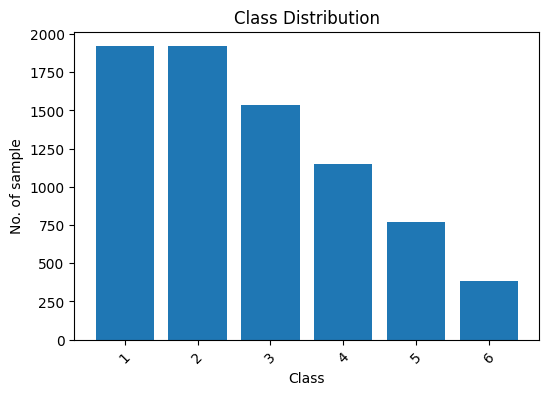

In [ ]:
# Check class base distribution and plot in graph
class_counts = metadata['stable_height'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('No. of sample')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Define the augmentation pipeline for the training dataset
train_augmentation = A.Compose([
    # Apply a horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),

    # Rotate the image by a random angle within the range of -20 to +20 degrees with a probability of 0.5
    A.Rotate(limit=20, p=0.5),

    # Sharpen the image with random alpha and lightness values; alpha controls the strength of sharpening
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),

    # Adjust brightness and contrast with specified limits, applied with a probability of 0.5
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    # Shift, scale, and rotate the image with defined limits for each transformation; applied with a probability of 0.5
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),

    # Normalize the image using the specified mean and standard deviation values for each channel
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the augmentation pipeline for the validation and test datasets
val_test_augmentation = A.Compose([
    # Normalize the image using the specified mean and standard deviation values for each channel
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Split the metadata into training and validation sets
train_metadata, val_metadata, train_labels, val_labels = train_test_split(
    metadata,
    metadata['stable_height'],
    test_size=0.2,
    random_state=42,
    stratify=metadata['stable_height']
)

# Load and preprocess the training images
train_images = np.array([
    load_and_preprocess_image(os.path.join(image_folder, str(fname) + '.jpg'))
    for fname in train_metadata['id']
])

# Apply augmentations to the training images
train_images = img_augmentation(train_images, train_augmentation)

# Preprocess the augmented training images to remove background and noise
train_images = preprocess_image(train_images)

# Load and preprocess the validation images
val_images = np.array([
    load_and_preprocess_image(os.path.join(image_folder, str(fname) + '.jpg'))
    for fname in val_metadata['id']
])

# Apply augmentations to the validation images
val_images = img_augmentation(val_images, val_test_augmentation)

# Preprocess the augmented validation images
val_images = preprocess_image(val_images)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[168, 125,  88],
        [168, 125,  88],
        [166, 124,  87],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[168, 125,  88],
        [168, 125,  88],
        [166, 124,  87],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[168, 125,  88],
        [168, 125,  88],
        [166, 124,  87],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
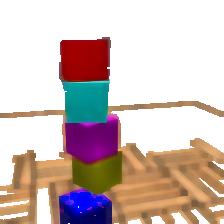

In [ ]:
train_images[0]

Code for inceptionresent metadata model

In [ ]:
def feature_create_resnet_model(n):
    # Define the input layer with a specific shape for the images (224x224 pixels with 3 color channels)
    image_input = Input(shape=(224, 224, 3))

    # Load the InceptionResnetV2 model pre-trained on ImageNet without the top classification layer
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Perform Global Average Pooling
    x = GlobalAveragePooling2D()(base_model(image_input))

    # Dropout regularization to reduce overfitting
    x = Dropout(rate=0.5)(x)

    # Dense layer with softmax activation
    output = Dense(n, activation='softmax')(x)

    # Create final model that maps the input to the output
    model = Model(inputs=image_input, outputs=output)

    return model

In [ ]:
# Define the features to be used for predicting the 'shapeset'
features = ["shapeset", "type", "total_height", "instability_type", "cam_angle"]

# Initialize the Label Encoder to convert categorical labels into a numeric format
label_encoder = LabelEncoder()

# Assign the metadata to a variable for training (this might be re-used later)
train_metadata = metadata

# Load and preprocess the training images using the IDs from the training metadata
train_images = np.array([
    load_and_preprocess_image(os.path.join(image_folder, str(fname) + '.jpg'))
    for fname in train_metadata['id']
])

# Apply augmentations to the training images
train_images = img_augmentation(train_images, train_augmentation)

# Preprocess the augmented training images
train_images = preprocess_image(train_images)

In [ ]:
features = ["shapeset", "type", "total_height", "instability_type", "cam_angle"]

# Load test metadata from CSV file
test_metadata = pd.read_csv("/content/COMP90086_2024_Project_test/test.csv")

# Iterate for each feature
for feature in features:
    # Extract the training labels for the current feature
    train_labels = train_metadata[feature]

    # Encode the labels to numeric values starting from zero
    train_labels = label_encoder.fit_transform(train_labels)

    # Create the model
    model = feature_create_resnet_model(len(np.unique(train_labels)))

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training images and labels
    history = model.fit(
        train_images,
        train_labels,
        epochs=10,
        batch_size=32,
    )

    predictions = []

    # Iterate over each image ID in the test metadata
    for img_id in test_metadata['id']:
        # Construct the file path for the test image
        img_path = os.path.join("/content/COMP90086_2024_Project_test/test", f'{img_id}.jpg')

        # Load the image and preprocess it
        test_img = load_img(img_path, target_size=(224, 224))  # Resize to match model input shape
        test_img = img_to_array(test_img)  # Convert image to array

        # Expand dimensions to add a batch dimension (model expects batches)
        test_img_segmented = np.expand_dims(test_img, axis=0)

        # Make predictions on the test image
        pred = model.predict(test_img_segmented)
        prediction = pred.argmax(axis=1) + 1  # Get the index of the highest probability class
        predictions.append(prediction[0])  # Append the prediction to the list

    # Add the predictions for the current feature to the test_metadata DataFrame
    test_metadata[feature] = predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
test_metadata.head()

,id,shapeset,type,total_height,instability_type,cam_angle
0,95,1,1,4,1,1
1,706,2,1,5,3,1
2,2854,2,2,2,3,1
3,3093,2,1,5,2,2
4,4283,1,2,4,2,1


In [ ]:
# Save the updated test_metadata with predictions to a new CSV file
test_metadata.to_csv('updated_test_metadata_inceptionresnet.csv', index=False)

In [ ]:
def create_combined_model(image_shape=(224, 224, 3), metadata_shape=(5,)):  # Using all 5 metadata features
    # Define the input layer for image data
    image_input = Input(shape=image_shape)

    # Load the InceptionResNetV2 model pre-trained on ImageNet without the top classification layer
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

    # Pass the image input through the base model and apply Global Average Pooling
    x = GlobalAveragePooling2D()(base_model(image_input))
    x = Dropout(rate=0.5)(x)  # Apply dropout for regularization

    # Define the input layer for metadata
    metadata_input = Input(shape=metadata_shape)
    y = Dense(64, activation='relu')(metadata_input)
    y = Dropout(0.3)(y)
    y = Dense(32, activation='relu')(y)

    # Concatenate the outputs from the image and metadata branches
    combined = Concatenate()([x, y])

    # Add fully connected layers after concatenation
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu')(z)

    # Final output layer for predicting stable height with 6 classes
    output = Dense(6, activation='softmax')(z)

    # Create the final combined model
    model = Model(inputs=[image_input, metadata_input], outputs=output)

    return model

In [ ]:
# Create the combined model with specified input shapes
model = create_combined_model()

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary to review the architecture
model.summary()

In [ ]:
# Split the metadata into training and validation sets
train_metadata, val_metadata, train_labels, val_labels = train_test_split(
    metadata,
    metadata['stable_height'],
    test_size=0.2,
    random_state=42,
    stratify=metadata['stable_height']
)

# Prepare the training and validation metadata by dropping id and label columns
train_metadata_new = train_metadata.drop(columns=['id', 'stable_height'])
val_metadata_new = val_metadata.drop(columns=['id', 'stable_height'])

# Load and preprocess training images
train_images = np.array([
    load_and_preprocess_image(os.path.join(image_folder, str(fname) + '.jpg'))
    for fname in train_metadata['id']
])

# Apply image augmentations to the training images
train_images = img_augmentation(train_images, train_augmentation)

# Further preprocess the training images
train_images = preprocess_image(train_images)

# Load and preprocess validation images
val_images = np.array([
    load_and_preprocess_image(os.path.join(image_folder, str(fname) + '.jpg'))
    for fname in val_metadata['id']
])

# Augmentvalidation images
val_images = img_augmentation(val_images, val_test_augmentation)

# Preprocess validation images
val_images = preprocess_image(val_images)

In [ ]:
# Train the model
history = model.fit(
    [train_images, train_metadata_new],
    train_labels - 1,
    validation_data=([val_images, val_metadata_new], val_labels - 1),
    epochs=20,
    batch_size=32,
)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 172s 160ms/step - accuracy: 0.2373 - loss: 1.7029 - val_accuracy: 0.2174 - val_loss: 5.7345
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.3468 - loss: 1.4175 - val_accuracy: 0.2318 - val_loss: 4.7753
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.3739 - loss: 1.2946 - val_accuracy: 0.2936 - val_loss: 10.4832
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.4159 - loss: 1.2141 - val_accuracy: 0.4375 - val_loss: 1.2601
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.4288 - loss: 1.1816 - val_accuracy: 0.4681 - val_loss: 1.1291
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.4498 - loss: 1.1509 - val_accuracy: 0.3887 - val_loss: 2.5958
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.4472 - loss: 1.1209 - val_accuracy: 0.1947 - val_loss: 6.4757
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.4716 - loss:

In [ ]:
# Save model in .keras file
model.save(f'inceptionresnet_metadatamodel.keras')

In [ ]:
# Define the folder containing test images and load the test metadata
test_image_folder = '/content/COMP90086_2024_Project_test/test'
test_metadata = pd.read_csv("/content/updated_test_metadata_inceptionresnet.csv")  # Load the CSV with metadata

# Load and preprocess test images
test_images = np.array([
    load_and_preprocess_image(os.path.join(test_image_folder, str(fname) + '.jpg'))
    for fname in test_metadata['id']  # Use the IDs from the test metadata to load images
])

# Apply augmentations to the test images
test_images = img_augmentation(test_images, train_augmentation)

# Preprocess the test images
test_images = preprocess_image(test_images)
print(f"Processed test images shape: {test_images.shape}")

In [ ]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1920 non-null   int64
 1   shapeset          1920 non-null   int64
 2   type              1920 non-null   int64
 3   total_height      1920 non-null   int64
 4   instability_type  1920 non-null   int64
 5   cam_angle         1920 non-null   int64
dtypes: int64(6)
memory usage: 90.1 KB


In [ ]:
# Formatting to use only metadata values
test_metadata_values = test_metadata[["shapeset", "type", "total_height", "instability_type", "cam_angle"]]

# Make prediction
pred = model.predict([test_images,test_metadata_values])
predictions = pred.argmax(axis=1)+1

# Add predictions to the DataFrame and save it to a new CSV
test_metadata['stable_height'] = predictions
test_metadata[['id','stable_height']].to_csv('/content/prediction_metadata_inceptionresent.csv', index=False)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
